In [1]:
%pylab inline
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from scipy import linalg

Populating the interactive namespace from numpy and matplotlib


## IoT devices communicating with the HOMEBOX
Assuming that the number of devices at home is at most 2000. Each of them have a random sequence associated with them. Let us generate these random sequences.

### Algorithm 1: Extracting signals purely through correlation

In [3]:
# Defining signature of each signal
sign_length = 400 
max_users = 2000
sign_matrix = 2*np.random.randint(2,size=(sign_length,max_users)) - 1

In [4]:
test_vec_1 = np.roll(sign_matrix[:,23],100)

# Correlating with song 23
correl_mat_t1 = (1.0/sign_length)*((linalg.circulant(sign_matrix[:,23]).transpose()))
sign_correlation_t1 = (correl_mat_t1.dot(test_vec_1))

# Correlating with song 20
correl_mat_t2 = (1.0/sign_length)*((linalg.circulant(sign_matrix[:,20]).transpose()))
sign_correlation_t2 = (correl_mat_t2.dot(test_vec_1))

(-0.2, 1)

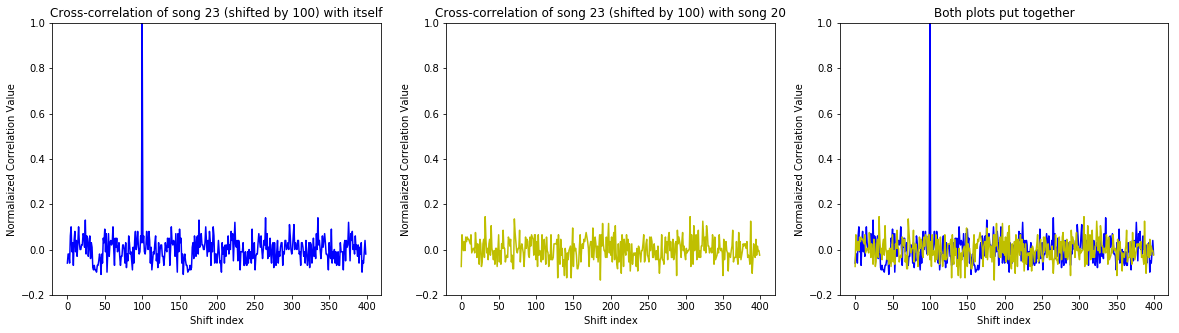

In [5]:
fig = plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.plot(sign_correlation_t1,'b')
plt.title('Cross-correlation of song 23 (shifted by 100) with itself')
plt.xlabel('Shift index')
plt.ylabel('Normalaized Correlation Value')
plt.ylim((-0.2,1))

plt.subplot(1, 3, 2)
plt.plot(sign_correlation_t2, 'y')
plt.title('Cross-correlation of song 23 (shifted by 100) with song 20')
plt.xlabel('Shift index')
plt.ylabel('Normalaized Correlation Value')
plt.ylim((-0.2,1))

plt.subplot(1, 3, 3)
plt.plot(sign_correlation_t1,'b')
plt.plot(sign_correlation_t2, 'y')
plt.title('Both plots put together')
plt.xlabel('Shift index')
plt.ylabel('Normalaized Correlation Value')
plt.ylim((-0.2,1))

In [6]:
index_present = [40, 100, 312] #devices
signal_stengths = [10, 10, 8] # alphas
shifts = [13, 20, 45] # taus

In [7]:
# Defining the signal y
combosignal = signal_stengths[0]*np.roll(sign_matrix[:,index_present[0]],shifts[0]) + signal_stengths[1]*np.roll(sign_matrix[:,index_present[1]],shifts[1]) + signal_stengths[2]*np.roll(sign_matrix[:,index_present[2]],shifts[2])

Text(0,0.5,'Normalized Correlation Value')

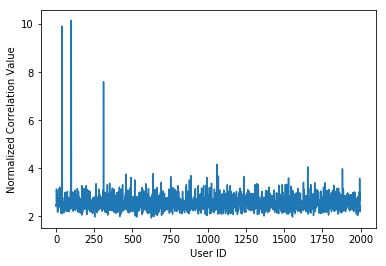

In [8]:
# Trying correlation to see if we can extract the signal
sign_correlation = np.zeros((sign_length, max_users))
max_correl = np.zeros(max_users)
index_max_correl = np.zeros(max_users)

#find the max correlations for each user ID
for j in range(max_users):
    correl_mat = (1.0/sign_length)*((linalg.circulant(sign_matrix[:,j]).transpose()))
    sign_correlation[:,j] = (correl_mat.dot(combosignal))
    max_correl[j] = max(abs(sign_correlation[:,j]))
    index_max_correl[j] = argmax(abs(sign_correlation[:,j]))
plt.plot(max_correl)
plt.xlabel('User ID')
plt.ylabel('Normalized Correlation Value')

In [9]:
max_1 = int(argmax(max_correl))
max_correl[max_1] = 0
max_2 = int(argmax(max_correl))
max_correl[max_2] = 0
max_3 = int(argmax(max_correl))

print(max_1, max_2, max_3)

100 40 312


### Algorithm 2: Extracting signals through correlation and least squares

In [10]:
shift_1 = int(index_max_correl[max_1])
print(shift_1)
first_vector = np.roll(sign_matrix[:,max_1], shift_1)

shift_2 = int(index_max_correl[max_2])
print(shift_2)
second_vector = np.roll(sign_matrix[:,max_2], shift_2)

shift_3 = int(index_max_correl[max_3])
print(shift_3)
third_vector = np.roll(sign_matrix[:,max_3], shift_3)

20
13
45


In [11]:
def least_squares(A, b):
    return np.linalg.inv(A.T.dot(A)).dot(A.T).dot(b)

In [12]:
A = (np.vstack((first_vector.T, second_vector.T, third_vector.T))).T
b = combosignal

alpha = least_squares(A,b)
print(alpha)

[10. 10.  8.]


#### Trial: 2

In [13]:
sign_length = 400 
max_users = 2000
sign_matrix = 2*np.random.randint(2,size=(sign_length,max_users)) - 1

Out of 2000 devices at home, for the duration of interest, only 4 devices are awake and sending something. They are user numbers [40, 100, 312, 350]. We will give them varying signal strength.

In [14]:
index_present = [40, 100, 312, 350] # device values
signal_stengths = [100, 10, 8, 0.02] # alpha values

Creating a combo received signal at the homebox with shifts

In [15]:
shifts = [13, 20, 45, 34] #taus
combosignal = np.zeros(sign_length)
for i in range(len(index_present)):
    signal_to_be_added = signal_stengths[i]*np.roll(sign_matrix[:,index_present[i]],shifts[i])
    combosignal = combosignal + signal_to_be_added

Now we will look for different signatures in the combo signal

In [16]:
sign_correlation = np.zeros((sign_length, max_users))
max_correl = np.zeros(max_users)
index_max_correl = np.zeros(max_users)


#find the max correlations for each user ID
for j in range(max_users):
    correl_mat = (1.0/sign_length)*((linalg.circulant(sign_matrix[:,j]).transpose()))
    sign_correlation[:,j] = (correl_mat.dot(combosignal))
    max_correl[j] = max(abs(sign_correlation[:,j]))
    index_max_correl[j] = argmax(abs(sign_correlation[:,j]))

Text(0,0.5,'Normalaized Correlation Value')

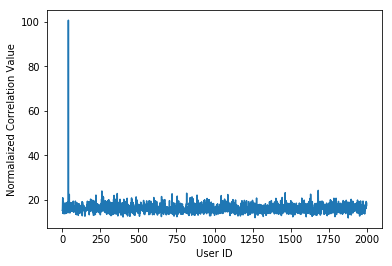

In [17]:
plot(max_correl)
plt.xlabel('User ID')
plt.ylabel('Normalaized Correlation Value')

In [18]:
max_1 = int(argmax(max_correl))
max_1

40

In [19]:
#ind = np.argpartition(max_correl, -3)[-3:]
#ind
shift_1 = int(index_max_correl[max_1])
shift_1

13

We see only 1 peak when we should have seen three/four.. Lets assume that a genie told us the level of the highest signal to be 100. We shall now remove it from the signal to see if we can find the other peaks.

In [20]:
residue = combosignal - 100*np.roll(sign_matrix[:,max_1], shift_1)

Text(0,0.5,'Normalaized Correlation Value')

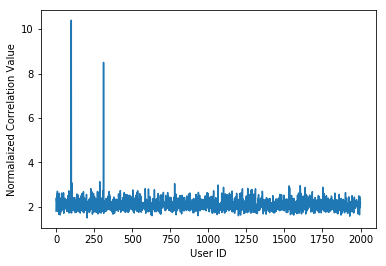

In [21]:
# Now we repeat correlation technique to find new peaks
sign_correlation = np.zeros((sign_length, max_users))
max_correl = np.zeros(max_users)
index_max_correl = np.zeros(max_users)

#find the max correlations for each user ID
for j in range(max_users):
    correl_mat = (1.0/sign_length)*((linalg.circulant(sign_matrix[:,j]).transpose()))
    sign_correlation[:,j] = (correl_mat.dot(residue))
    max_correl[j] = max(abs(sign_correlation[:,j]))
    index_max_correl[j] = argmax(abs(sign_correlation[:,j]))

plot(max_correl)
plt.xlabel('User ID')
plt.ylabel('Normalaized Correlation Value')

Wow! We now see the two peaks that we expected to see! Huzzah! But we do not usually have a genie to tell us the signal level. So what is a good proxy for the actual signal level? Maybe the max correlation value which is the projection of the combo signal onto that signature space? Lets do it one by one starting from the original signal.

## Algorithm 3: Correlate and remove one

40
13
100.6522


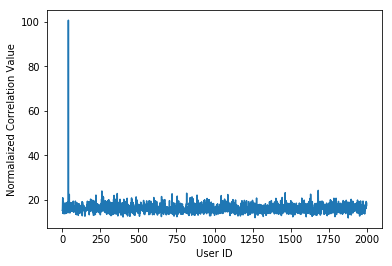

In [22]:
index_present = [40, 100, 312, 350]
signal_stengths = [100, 10, 8, 0.02]
shifts = [13, 20, 45, 34]
combosignal = np.zeros(sign_length)
for i in range(len(index_present)):
    signal_to_be_added = signal_stengths[i]*np.roll(sign_matrix[:,index_present[i]],shifts[i])
    combosignal = combosignal + signal_to_be_added

sign_correlation = np.zeros((sign_length, max_users))
max_correl = np.zeros(max_users)
index_max_correl = np.zeros(max_users)
for j in range(max_users):
    correl_mat = (1.0/sign_length)*((linalg.circulant(sign_matrix[:,j]).transpose()))
    sign_correlation[:,j] = (correl_mat.dot(combosignal))
    max_correl[j] = max(abs(sign_correlation[:,j]))
    index_max_correl[j] = argmax(abs(sign_correlation[:,j]))


max_1 = int(argmax(max_correl))
print(max_1)
shift_1 = int(index_max_correl[max_1])
print(shift_1)

alpha_1 = max_correl[max_1]
print(alpha_1)

plot(max_correl)
plt.xlabel('User ID')
plt.ylabel('Normalaized Correlation Value')

first_vector = np.roll(sign_matrix[:,max_1], shift_1)

#index_present = [40, 100, 312, 350] devices
#signal_stengths = [100, 10, 8, 0.02] alphas
#shifts = [13, 20, 45, 34] taus


We will now remove the 'projected' signal from the combo signal and look for the second highest.

100
20
10.396238999999996


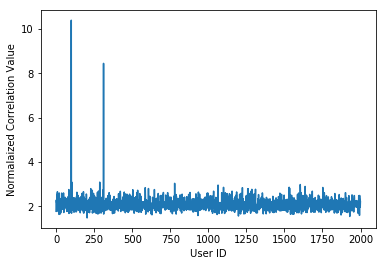

In [23]:
#alpha_1 = max_correl[max_1]
residue = combosignal - alpha_1*first_vector

sign_correlation = np.zeros((sign_length, max_users))
max_correl = np.zeros(max_users)
index_max_correl = np.zeros(max_users)

for j in range(max_users):
    correl_mat = (1.0/sign_length)*((linalg.circulant(sign_matrix[:,j]).transpose()))
    sign_correlation[:,j] = (correl_mat.dot(residue))
    max_correl[j] = max(abs(sign_correlation[:,j]))
    index_max_correl[j] = argmax(abs(sign_correlation[:,j]))

plot(max_correl)
plt.xlabel('User ID')
plt.ylabel('Normalaized Correlation Value')

max_2 = int(argmax(max_correl))
print(max_2)
shift_2 = int(index_max_correl[max_2])
print(shift_2)

alpha_2 = max_correl[max_2]
print(alpha_2)

second_vector = np.roll(sign_matrix[:,max_2], shift_2)

#index_present = [40, 100, 312, 350] devices
#signal_stengths = [100, 10, 8, 0.02] alphas
#shifts = [13, 20, 45, 34] taus


Now we'll remove the second peak and look for the third peak.

312
45
7.931573049999993


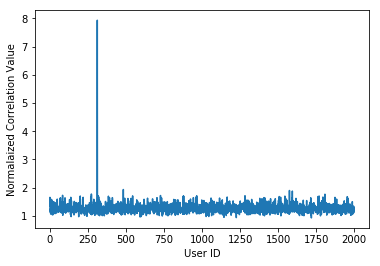

In [24]:
residue = combosignal - alpha_1*first_vector - alpha_2*second_vector

sign_correlation = np.zeros((sign_length, max_users))
max_correl = np.zeros(max_users)
index_max_correl = np.zeros(max_users)

for j in range(max_users):
    correl_mat = (1.0/sign_length)*((linalg.circulant(sign_matrix[:,j]).transpose()))
    sign_correlation[:,j] = (correl_mat.dot(residue))
    max_correl[j] = max(abs(sign_correlation[:,j]))
    index_max_correl[j] = argmax(abs(sign_correlation[:,j]))

plot(max_correl)
plt.xlabel('User ID')
plt.ylabel('Normalaized Correlation Value')

max_3 = int(argmax(max_correl))
print(max_3)
shift_3 = int(index_max_correl[max_3])
print(shift_3)

alpha_3 = max_correl[max_3]
print(alpha_3)

third_vector = np.roll(sign_matrix[:,max_3], shift_3)

#index_present = [40, 100, 312, 350] devices
#signal_stengths = [100, 10, 8, 0.02] alphas
#shifts = [13, 20, 45, 34] taus


We are yet to see the fourth peak. Maybe we'll see it when we remove the third peak. Let's see!

Text(0,0.5,'Normalaized Correlation Value')

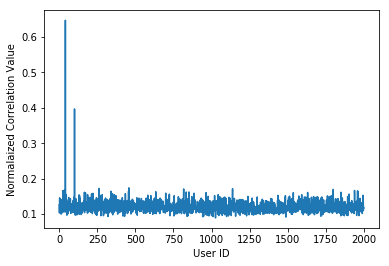

In [25]:
residue = combosignal - alpha_1*first_vector - alpha_2*second_vector - alpha_3*third_vector

sign_correlation = np.zeros((sign_length, max_users))
max_correl = np.zeros(max_users)
index_max_correl = np.zeros(max_users)

for j in range(max_users):
    correl_mat = (1.0/sign_length)*((linalg.circulant(sign_matrix[:,j]).transpose()))
    sign_correlation[:,j] = (correl_mat.dot(residue))
    max_correl[j] = max(abs(sign_correlation[:,j]))
    index_max_correl[j] = argmax(abs(sign_correlation[:,j]))

plot(max_correl)
plt.xlabel('User ID')
plt.ylabel('Normalaized Correlation Value')


#index_present = [40, 100, 312, 350] devices
#signal_stengths = [100, 10, 8, 0.02] alphas
#shifts = [13, 20, 45, 34] taus


In [ ]:
int(argmax(max_correl))

Oh no! Garbage alert! What went wrong? Maybe, the way we extracted the signals out introduced more noise? After finding the location of the first three peaks, we can use a better method to estimate the peak values. Let's try to project all three simultaneosly onto the subspace spanned by these signatures. This is the least squares estimate of the coefficients.

In [26]:
A = (np.vstack((first_vector.T, second_vector.T, third_vector.T))).T
b = combosignal

alpha = least_squares(A,b)
alpha

array([100.00219047,   9.99948096,   8.00016167])

350
34


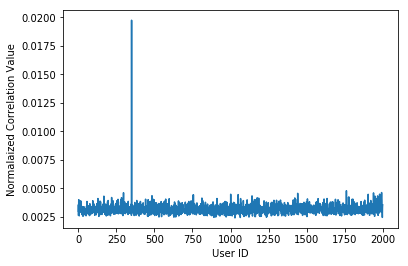

In [28]:
residue = combosignal - alpha[0]*first_vector - alpha[1]*second_vector - alpha[2]*third_vector

sign_correlation = np.zeros((sign_length, max_users))
max_correl = np.zeros(max_users)
index_max_correl = np.zeros(max_users)

for j in range(max_users):
    correl_mat = (1.0/sign_length)*((linalg.circulant(sign_matrix[:,j]).transpose()))
    sign_correlation[:,j] = (correl_mat.dot(residue))
    max_correl[j] = max(abs(sign_correlation[:,j]))
    index_max_correl[j] = argmax(abs(sign_correlation[:,j]))

plot(max_correl)
plt.xlabel('User ID')
plt.ylabel('Normalaized Correlation Value')

max_4 = int(argmax(max_correl))
shift_4 = int(index_max_correl[max_4])
print(max_4)
print(shift_4)

In [29]:
max_4

350

## Algorithm 4: Now we see a very clear peak at 350! Least square estimate on all the signatures gives us the following.

In [ ]:
fourth_vector = np.roll(sign_matrix[:,max_4], shift_4)

A = (np.vstack((first_vector.T, second_vector.T, third_vector.T, fourth_vector.T))).T
b = combosignal

alpha = least_squares(A,b)

alpha

## Final OMP algorithm: Coding the whole process up into a function.

In [ ]:
def OMP(max_users, sparsity, sign_length, measurements, codebook):
    residue = measurements.copy()
    indices = []
    recovered_codewords = []
    
    for i in range(sparsity):
        
        # Choose highest-correlated codeword and add to collection  
        max_correl = np.zeros(max_users)
        index_max_correl = np.zeros(max_users)

        for j in range(max_users):
            correl_mat = (1.0/sign_length)*((linalg.circulant(sign_matrix[:,j]).transpose()))
            max_correl[j] = max(abs(correl_mat.dot(residue)))
            index_max_correl[j] = argmax(abs(correl_mat.dot(residue)))
        
        max_index = int(argmax(max_correl))
        shift_index = int(index_max_correl[max_index])
        shifted_codeword = np.roll(codebook[:,max_index], shift_index)
        indices.append(max_index)
        recovered_codewords.append(shifted_codeword)
        
        # Least-squares projection
        A = np.array(recovered_codewords).T
        b = measurements
        xhat = least_squares(A, b)
        
        # Find component parallel to subspace to use for next measurement
        residue = b - A.dot(xhat)
    
    recovered_signal = np.zeros(max_users)
    for i, x in zip(indices, xhat):
        recovered_signal[i] = x

    return residue, recovered_signal